<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you load this notebook by clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

There is a lot of freedom in this homework to design write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 63 (delta 8), reused 40 (delta 3), pack-reused 3
Receiving objects: 100% (63/63), 53.61 MiB | 2.22 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=13151 sha256=7bc5556fa1cd720ce5b951d9868a0b7ed59447c1aeac792117dd389f784412a9
  Stored in directory: /tmp/pip-ephem-wheel-cache-ybkp791z/wheels/57/0f/bb/944d7d82f3694eb93da15489be662af23958a0c45732023161
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [3]:
import numpy as np
from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


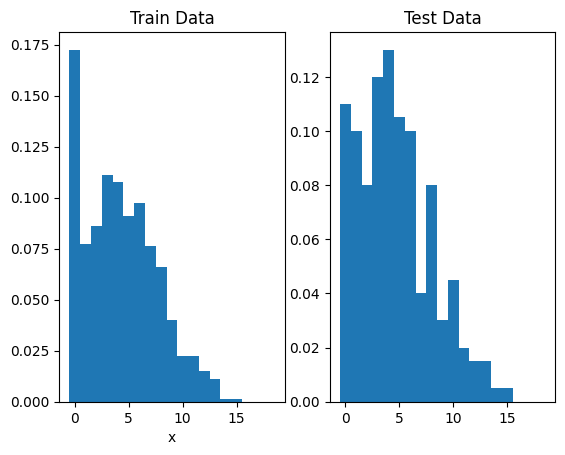

Dataset 2


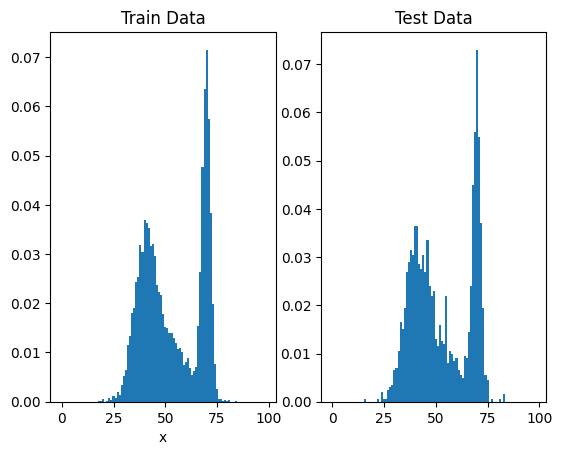

In [3]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^{d}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tqdm

quiet = True

def train(model, train_loader, optimizer, scheduler, epoch, grad_clip=None):
  model.train()
  
  train_losses = []
  for x in train_loader:
    x = x.cuda().contiguous()
    loss = model.loss(x)
    optimizer.zero_grad()
    loss.backward()
    if grad_clip:
      torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    scheduler.step()
    train_losses.append(loss.item())
  return train_losses

def eval_loss(model, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.cuda().contiguous()
      loss = model.loss(x)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)

  return avg_loss.item()


def get_lr(step, total_steps, warmup_steps, use_cos_decay):
    if step < warmup_steps:
        # Linear warmup
        mul = (step + 1) / warmup_steps
        return mul
    else:
        # Cosine decay
        if use_cos_decay:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return (1 + math.cos(math.pi * progress)) / 2
        else:
            return 1

def train_epochs(model, train_loader, test_loader, train_args):
  epochs, lr = train_args['epochs'], train_args['lr']
  grad_clip = train_args.get('grad_clip', None)
  warmup_steps = train_args.get('warmup', 0)
  use_cos_decay = train_args.get('use_cos_decay', False)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  total_steps = epochs * len(train_loader)
  scheduler = torch.optim.lr_scheduler.LambdaLR(
      optimizer, 
      lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
  )

  train_losses = []
  test_losses = [eval_loss(model, test_loader)]
  for epoch in tqdm.tqdm(range(epochs)):
    model.train()
    train_losses.extend(train(model, train_loader, optimizer, scheduler, epoch, grad_clip))
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    if not quiet:
      print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

  return train_losses, test_losses

class Histogram(nn.Module):
  def __init__(self, d):
    super().__init__()
    self.d = d
    self.logits = nn.Parameter(torch.zeros(d), requires_grad=True)

  def loss(self, x):
    logits = self.logits.unsqueeze(0).repeat(x.shape[0], 1) # batch_size x d
    return F.cross_entropy(logits, x.long())

  def get_distribution(self):
    distribution = F.softmax(self.logits, dim=0)
    return distribution.detach().cpu().numpy()

In [5]:
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  model = Histogram(d).cuda()
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           dict(epochs=20, lr=1e-1))
  distribution = model.get_distribution()
  return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



/home/rll/miniconda/envs/lit/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/rll/miniconda/envs/lit/lib/python3.10/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 291.69it/s]


Final Test Loss: 2.5549


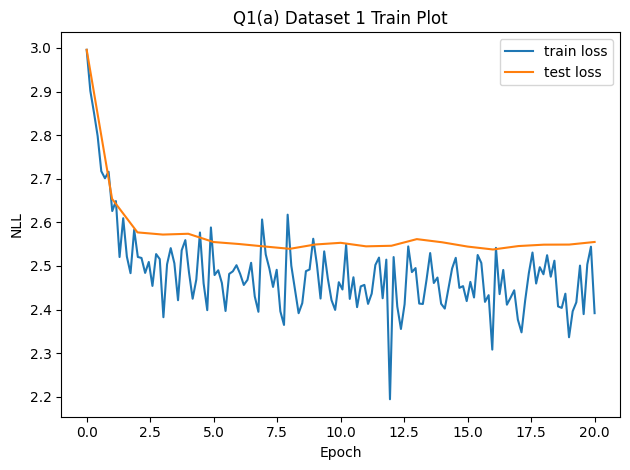

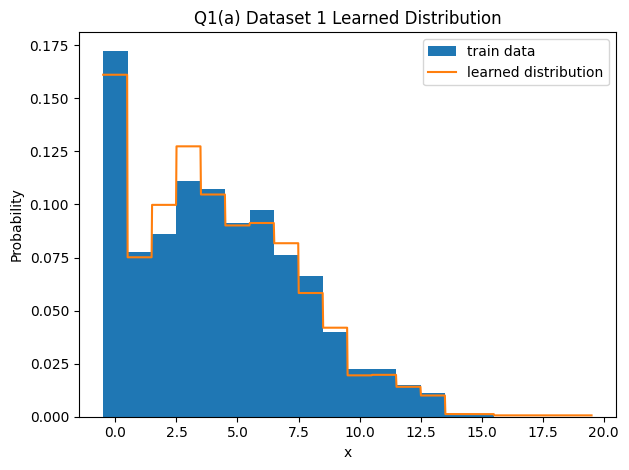

In [6]:
q1_save_results(1, 'a', q1_a)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 65.94it/s]


Final Test Loss: 3.6819


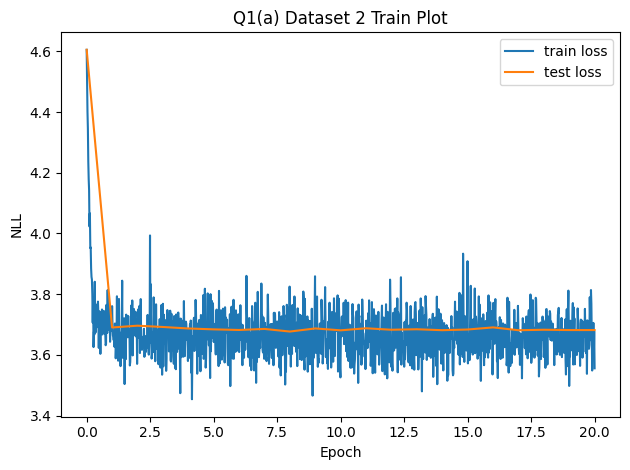

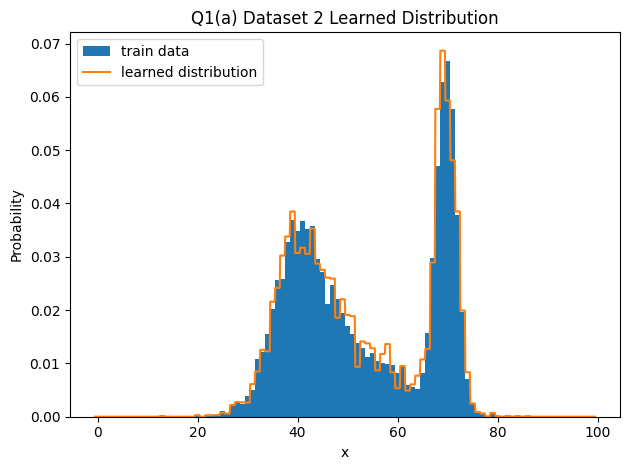

In [7]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [8]:
class MixtureOfLogistics(nn.Module):
  def __init__(self, d, n_mix=4):
    super().__init__()
    self.d = d
    self.n_mix = n_mix

    self.logits = nn.Parameter(torch.zeros(n_mix), requires_grad=True)
    self.means = nn.Parameter(torch.arange(n_mix).float() / (n_mix - 1) * d, 
                              requires_grad=True)
    self.log_scales = nn.Parameter(torch.randn(n_mix), requires_grad=True)

  def forward(self, x):
    d = self.d
    x = x.float()
    x = x.unsqueeze(1).repeat(1, self.n_mix) # b x n_mix
    means, log_scales = self.means.unsqueeze(0), self.log_scales.unsqueeze(0) # 1 x n_mix
    inv_scales = torch.exp(-log_scales)

    plus_in = inv_scales * (x + 0.5 - means)
    min_in = inv_scales * (x - 0.5 - means)

    cdf_plus = torch.sigmoid(plus_in) # CDF of logistics at x + 0.5
    cdf_min = torch.sigmoid(min_in) # CDF of logistics at x - 0.5

    cdf_delta = cdf_plus - cdf_min # probability of x in bin [x - 0.5, x + 0.5]
    log_cdf_delta = torch.log(torch.clamp(cdf_delta, min=1e-12))
    log_cdf_plus = torch.log(torch.clamp(torch.sigmoid(inv_scales * (0.5 - means)),
                                                       min=1e-12))
    log_cdf_min = torch.log(torch.clamp(1 - torch.sigmoid(inv_scales * (d - 1.5 - means)),
                                        min=1e-12))

    x_log_probs = torch.where(x < 0.001, log_cdf_plus,
                              torch.where(x > d - 1 - 1e-3,
                                          log_cdf_min, log_cdf_delta))
    pi_log_probs = F.log_softmax(self.logits, dim=0).unsqueeze(0)
    log_probs = x_log_probs + pi_log_probs
    return torch.logsumexp(log_probs, dim=1)

  def loss(self, x):
    return -torch.mean(self(x))

  def get_distribution(self):
    with torch.no_grad():
      x = torch.FloatTensor(np.arange(self.d)).cuda()
      distribution = self(x).exp()
    return distribution.detach().cpu().numpy()


In [9]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  model = MixtureOfLogistics(d, n_mix=4).cuda()
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           dict(epochs=10, lr=1e-1))
  distribution = model.get_distribution()
  return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 184.91it/s]

Final Test Loss: 2.5465


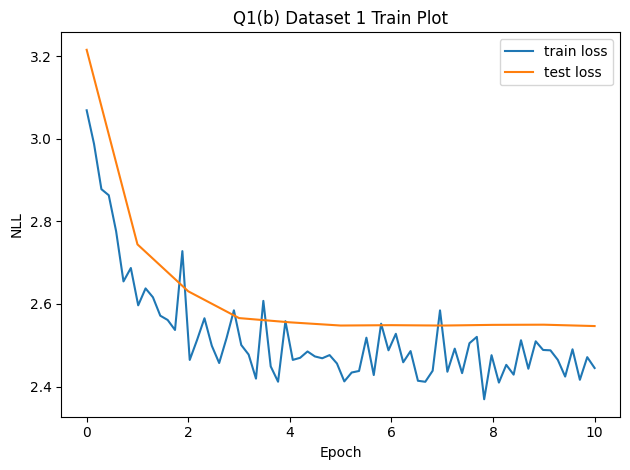

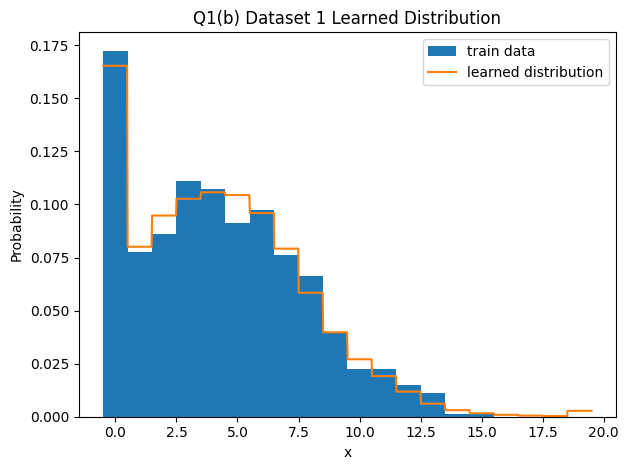

In [10]:
q1_save_results(1, 'b', q1_b)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 23.21it/s]


Final Test Loss: 3.6724


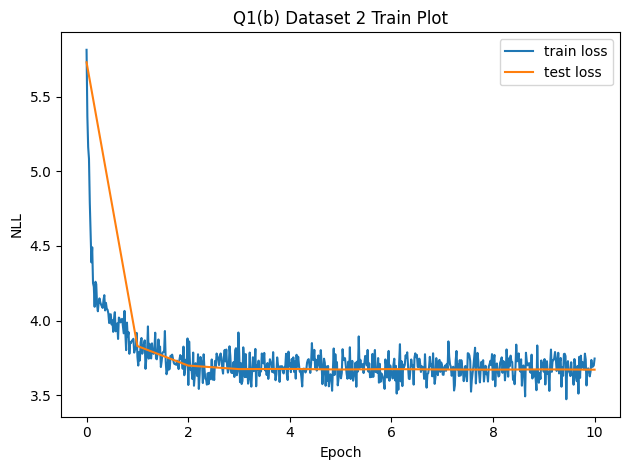

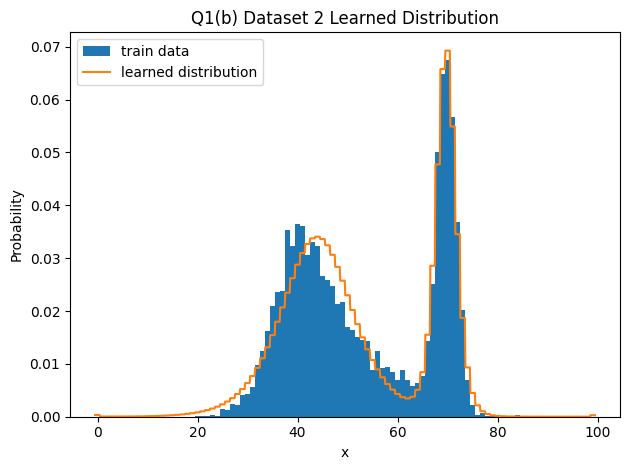

In [11]:
q1_save_results(2, 'b', q1_b)

# Question 2 PixelCNNs

Now, you will train more powerful PixelCNN models on the shapes dataset and MNIST. In addition, we will extend to modeling colored datasets.

Run the cell below to visualize the two datasets binary datasets

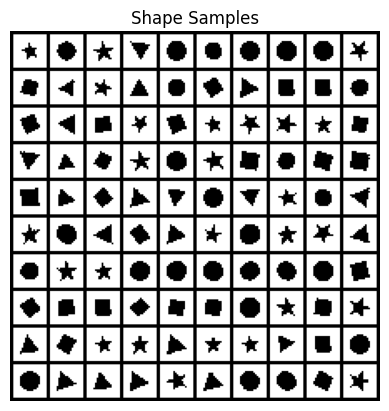

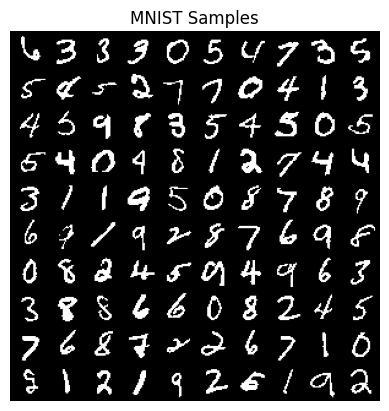

In [12]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class MaskConv2d(nn.Conv2d):
  def __init__(self, mask_type, *args, conditional_size=None, 
               color_conditioning=False, **kwargs):
    assert mask_type == 'A' or mask_type == 'B'
    super().__init__(*args, **kwargs)
    self.conditional_size = conditional_size
    self.color_conditioning = color_conditioning
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask(mask_type)
    if self.conditional_size:
      if len(self.conditional_size) == 1:
        self.cond_op = nn.Linear(conditional_size[0], self.out_channels)
      else:
        self.cond_op = nn.Conv2d(conditional_size[0], self.out_channels,
                                 kernel_size=3, padding=1)

  def forward(self, input, cond=None):
    batch_size = input.shape[0]
    out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                   self.padding, self.dilation, self.groups)
    if self.conditional_size:
      if len(self.conditional_size) == 1:
        # Broadcast across height and width of image and add as conditional bias
        out = out + self.cond_op(cond).view(batch_size, -1, 1, 1)
      else:
        out = out + self.cond_op(cond)
    return out

  def create_mask(self, mask_type):
    k = self.kernel_size[0]
    self.mask[:, :, :k // 2] = 1
    self.mask[:, :, k // 2, :k // 2] = 1
    if self.color_conditioning:
      assert self.in_channels % 3 == 0 and self.out_channels % 3 == 0
      one_third_in, one_third_out = self.in_channels // 3, self.out_channels // 3
      if mask_type == 'B':
        self.mask[:one_third_out, :one_third_in, k // 2, k // 2] = 1
        self.mask[one_third_out:2*one_third_out, :2*one_third_in, k // 2, k // 2] = 1
        self.mask[2*one_third_out:, :, k // 2, k // 2] = 1
      else:
        self.mask[one_third_out:2*one_third_out, :one_third_in, k // 2, k // 2] = 1
        self.mask[2*one_third_out:, :2*one_third_in, k // 2, k // 2] = 1
    else:
      if mask_type == 'B':
        self.mask[:, :, k // 2, k // 2] = 1

class ResBlock(nn.Module):
  def __init__(self, in_channels, **kwargs):
    super().__init__()
    self.block = nn.ModuleList([
        nn.ReLU(),
        MaskConv2d('B', in_channels, in_channels // 2, 1, **kwargs),
        nn.ReLU(),
        MaskConv2d('B', in_channels // 2, in_channels // 2, 7, padding=3, **kwargs),
        nn.ReLU(),
        MaskConv2d('B', in_channels // 2, in_channels, 1, **kwargs)
    ])

  def forward(self, x, cond=None):
    out = x
    for layer in self.block:
      if isinstance(layer, MaskConv2d):
        out = layer(out, cond=cond)
      else:
        out = layer(out)
    return out + x

class LayerNorm(nn.LayerNorm):
  def __init__(self, color_conditioning, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.color_conditioning = color_conditioning

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()
    x_shape = x.shape
    if self.color_conditioning:
      x = x.contiguous().view(*(x_shape[:-1] + (3, -1)))
    x = super().forward(x)
    if self.color_conditioning:
      x = x.view(*x_shape)
    return x.permute(0, 3, 1, 2).contiguous()

class PixelCNN(nn.Module):
  def __init__(self, input_shape, n_colors, n_filters=64,
               kernel_size=7, n_layers=5, 
               conditional_size=None, use_resblock=False,
               color_conditioning=False):
    super().__init__()
    assert n_layers >= 2
    n_channels = input_shape[0]

    kwargs = dict(conditional_size=conditional_size, 
                  color_conditioning=color_conditioning)
    if use_resblock:
      block_init = lambda: ResBlock(n_filters, **kwargs)
    else:    
      block_init = lambda: MaskConv2d('B', n_filters, n_filters, 
                                      kernel_size=kernel_size,
                                      padding=kernel_size // 2, **kwargs)
    
    model = nn.ModuleList([MaskConv2d('A', n_channels, n_filters, 
                                      kernel_size=kernel_size,
                                      padding=kernel_size // 2, **kwargs)])
    for _ in range(n_layers):
      if color_conditioning:
        model.append(LayerNorm(color_conditioning, n_filters // 3))
      else:
        model.append(LayerNorm(color_conditioning, n_filters))
      model.extend([nn.ReLU(), block_init()])
    model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_filters, 1, **kwargs)])
    model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_colors * n_channels, 1, **kwargs)])

    if conditional_size:
      if len(conditional_size) == 1:
        self.cond_op = lambda x: x # No preprocessing conditional if one hot
      else:
        # For Grayscale PixelCNN (some preprocessing on the binary image)
        self.cond_op = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

    self.net = model
    self.input_shape = input_shape
    self.n_colors = n_colors
    self.n_channels = n_channels
    self.color_conditioning = color_conditioning
    self.conditional_size = conditional_size

  def forward(self, x, cond=None):
    batch_size = x.shape[0]
    out = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
    if self.conditional_size:
      cond = self.cond_op(cond)
    for layer in self.net:
      if isinstance(layer, MaskConv2d) or isinstance(layer, ResBlock):
        out = layer(out, cond=cond)
      else:
        out = layer(out)

    if self.color_conditioning:
      return out.view(batch_size, self.n_channels, self.n_colors, 
                      *self.input_shape[1:]).permute(0, 2, 1, 3, 4)
    else:
      return out.view(batch_size, self.n_colors, *self.input_shape)

  def loss(self, x, cond=None):
    return F.cross_entropy(self(x, cond=cond), x.long())

  def sample(self, n, cond=None):
    samples = torch.zeros(n, *self.input_shape).cuda()
    with torch.no_grad():
      for r in range(self.input_shape[1]):
        for c in range(self.input_shape[2]):
          for k in range(self.n_channels):
            logits = self(samples, cond=cond)[:, :, k, r, c]
            probs = F.softmax(logits, dim=1)
            samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
    return samples.permute(0, 2, 3, 1).cpu().numpy()

In [14]:
def q2_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  H, W = image_shape
  model = PixelCNN((1, H, W), 2, n_layers=5).cuda()

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           dict(epochs=10, lr=1e-3))
  samples = model.sample(100)
  return train_losses, test_losses, samples

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.51it/s]


Final Test Loss: 0.0403


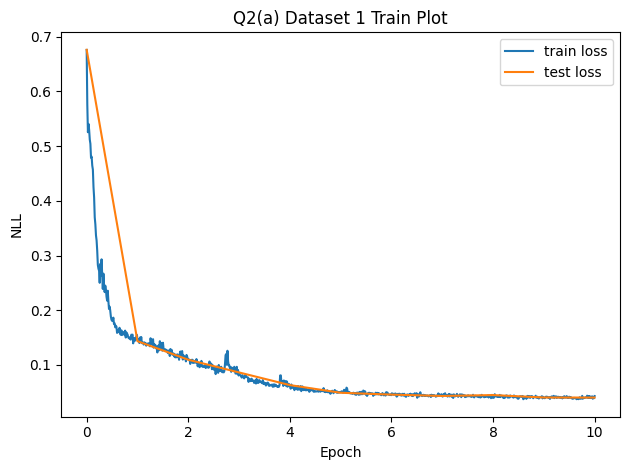

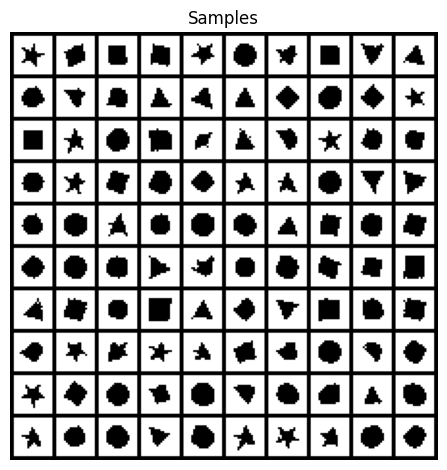

In [15]:
q2a_save_results(1, q2_a)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.15s/it]


Final Test Loss: 0.0755


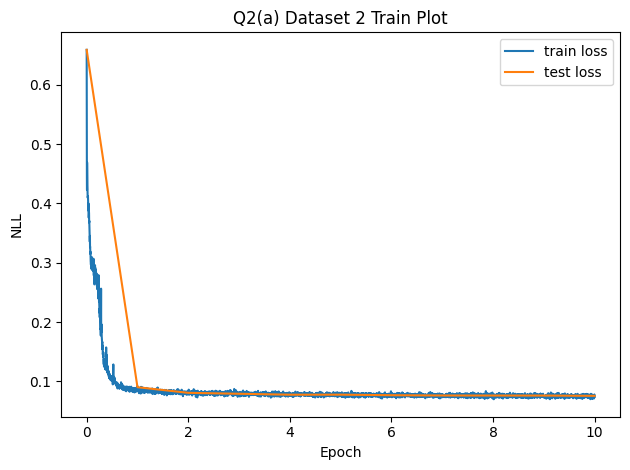

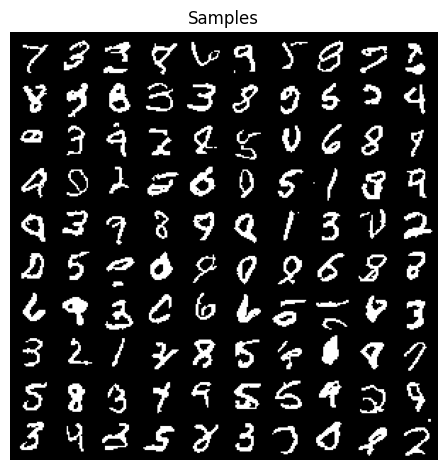

In [16]:
q2a_save_results(2, q2_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

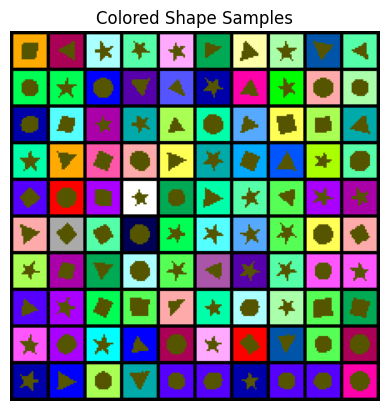

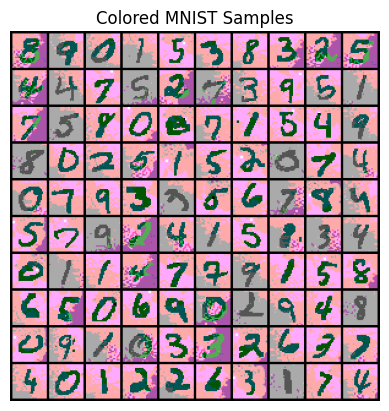

In [17]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [18]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  H, W, C = image_shape
  epochs = 15
      
  if dset_id == 1:
    model = PixelCNN((C, H, W), 4, n_filters=120, n_layers=8, use_resblock=True).cuda()
    train_args = dict(epochs=epochs, lr=1e-3, grad_clip=1)
  else:
    model = PixelCNN((C, H, W), 4, n_filters=120, n_layers=8, use_resblock=True).cuda()
    train_args=dict(epochs=epochs, lr=1e-3, grad_clip=1)

    
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           train_args)
  samples = model.sample(100)
  print(samples.shape)
  return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:26<00:00,  1.78s/it]


(100, 20, 20, 3)
Final Test Loss: 0.0432


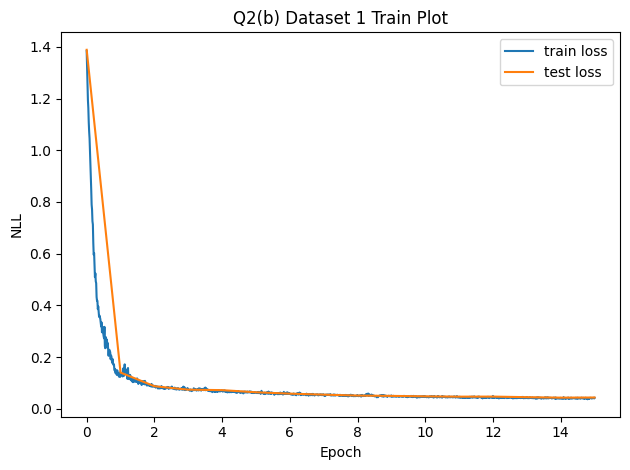

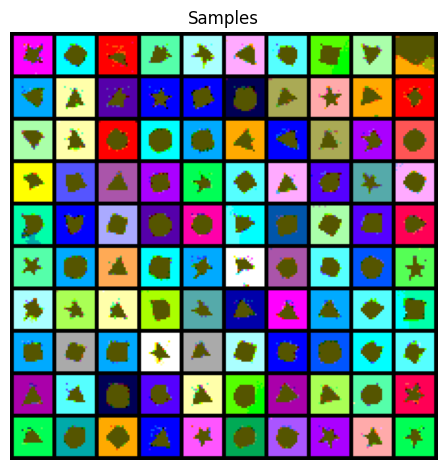

In [19]:
q2b_save_results(1, 'b', q2_b)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [04:52<00:00, 19.51s/it]


(100, 28, 28, 3)
Final Test Loss: 0.0799


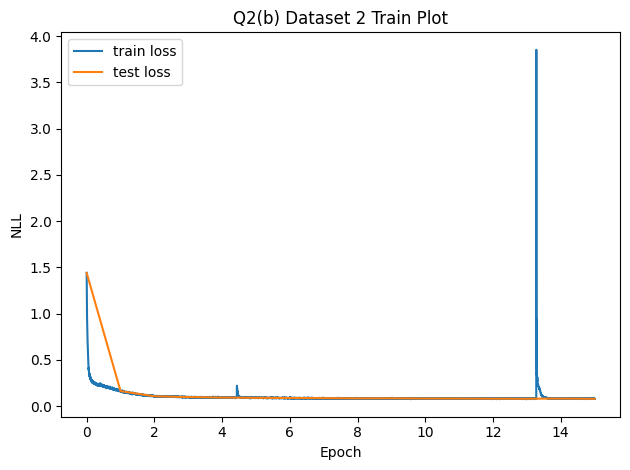

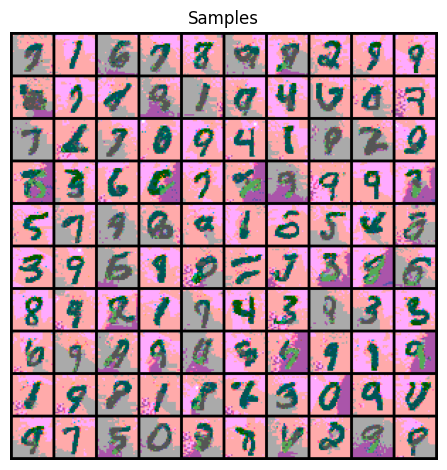

In [20]:
q2b_save_results(2, 'b', q2_b)

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer). 

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [1]:
import math
from dataclasses import dataclass
import time

import torch
import torch.nn as nn
from torch.nn import functional as F


@dataclass
class TransformerConfig:
    vocab_size: int
    block_size: int
    n_layer: int = 2
    n_head: int = 4
    n_embd: int = 128


class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()

        # feature projections
        self.kqv_projection = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        

    def forward(self, x, k_cache=None, v_cache=None):
        B, T, C = x.size()  

        # calculate q, k v
        q, k, v = self.kqv_projection(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        if k_cache is not None:
            assert v_cache is not None
            assert T == 1
            # concat previous cache with new k, v
            v = torch.cat([v_cache, v], dim=2) # (B, nh, 1 + T', hs)
            k = torch.cat([k_cache, k], dim=2) # (B, nh, 1 + T', hs)
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1))) # (B, nh, 1, 1 + T')
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))

        att = F.softmax(att, dim=-1)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # output projection
        return self.proj(y), k, v


class Block(nn.Module):
    """Transfromer Block"""
    
    def __init__(self, config):
        super().__init__()
        self.ln = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        
        self.mlp_sequence = nn.Sequential(
            nn.LayerNorm(config.n_embd),
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
        )

    def forward(self, x, k_cache=None, v_cache=None):
        _x = x
        x, k, v = self.attn(self.ln(x), k_cache, v_cache)
        x = _x + x
        x = x + self.mlp_sequence(x)
        return x, k, v


class Transformer(nn.Module):
    """Simple Transformer"""

    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.token_embeddings = nn.Embedding(config.vocab_size, config.n_embd)
        self.position_embeddings = nn.Embedding(config.block_size, config.n_embd)
        self.transformer_blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.layer_norm = nn.LayerNorm(config.n_embd)

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, start_idx=0, k_cache=None, v_cache=None):
        device = idx.device
        b, t = idx.size()
        assert (t <= self.block_size)
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) + start_idx  

        tok_emb = self.token_embeddings(idx)  # token embeddings of shape (b, t, n_embd)
        pos_emb = self.position_embeddings(pos)  # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb

        k_s = []
        v_s = []
        for idx, block in enumerate(self.transformer_blocks):
            if k_cache is not None:
                assert v_cache is not None
                k_i, v_i = k_cache[idx], v_cache[idx]
            else:
                k_i, v_i = None, None 
            x, k, v = block(x, k_i, v_i)
            k_s.append(k)
            v_s.append(v)

        logits = self.lm_head(self.layer_norm(x))
        return logits, k_s, v_s

    def loss(self, x):
        x_in, targets = x[:, :-1], x[:, 1:] # make target a shifted version of the original
        logits, _, _ = self(x_in)
        loss = F.cross_entropy(
            logits.reshape(-1, logits.size(-1)), targets.reshape(-1), ignore_index=-1
        )
        return loss

    @torch.no_grad()
    def generate(
        self, idx, max_new_tokens=None, temperature=1.0, cache=False, logit_mask=None
    ):
        """generate

        Args:
            idx (torch.Tensor): input indices
            max_new_tokens (int, optional): maximum number of tokens to generate. Defaults to None.
            temperature (float, optional): temperature for sampling. Defaults to 1.0.
            cache (bool, optional): whether to use caching. Defaults to False.
            logit_mask (torch.Tensor, optional): mask to apply to logits. Defaults to None, of shape (vocab_size,).
        """
        if max_new_tokens == None:
            max_new_tokens = self.block_size - idx.shape[-1]

        if logit_mask == None:
            logit_mask = torch.ones(self.vocab_size, dtype=int) 
            logit_mask[-1] = 0 # ignore last token, by default (usually sos)
            
        k_cache = None
        v_cache = None
           
        time_list = []
        for i in range(max_new_tokens):
            start_time = time.time()
            if cache:
                start_index = i
                idx_in = idx[:, -1:]
            else:
                start_index = 0
                idx_in = idx
            
            logits, k, v = self(idx_in, start_idx=start_index, k_cache=k_cache, v_cache=v_cache)
            if cache:
                k_cache = k
                v_cache = v

            # sample a token from the logits
            logits = logits[:, -1, :] / temperature
            if logit_mask is not None:
                logits[:, logit_mask == 0] = float("-inf") # mask out certain tokens

            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)

            time_list.append(time.time() - start_time)

            # append sampled token
            idx = torch.cat((idx, idx_next), dim=1)
        return idx, time_list

In [22]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
  image_shape: (H, W, 1), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  H, W, C = image_shape
  tf_config = TransformerConfig(
      vocab_size=3,
      block_size=H * W + 1, # plus one for sos token
  )
  model = Transformer(tf_config).cuda()
  sos_token = 2
  epochs = 15
      
  train_args = dict(epochs=epochs, lr=1e-3, grad_clip=1, use_cos_decay=True, warmup=1000)

  # train_data is of shape (B, Height, Width, Channels), convert to sequence of indices
  train_data = torch.tensor(train_data).permute(0, 3, 1, 2).contiguous().view(-1, H * W * C).long()
  test_data = torch.tensor(test_data).permute(0, 3, 1, 2).contiguous().view(-1, H * W * C).long()
    
  # append sos token to the start of each sequence
  train_data = torch.cat([sos_token * torch.ones(train_data.size(0), 1).long(), train_data], dim=1)
  test_data = torch.cat([sos_token * torch.ones(test_data.size(0), 1).long(), test_data], dim=1)

  train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=64)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)

  model.eval()
  time_s = time.time()
  idx = torch.ones(100, 1).long().cuda() * sos_token
  generated =  model.generate(idx)
  sequence, _ = generated 
  sequence = sequence[:, 1:] # remove sos token
  print(f"sample_time = {time.time() - time_s}")

  samples = sequence.view(-1, C, H, W).permute(0, 2, 3, 1).cpu().numpy()
  samples = sequence.view(-1, C, H, W).permute(0, 2, 3, 1).cpu().numpy()
  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:45<00:00,  3.03s/it]


sample_time = 1.5549962520599365
Final Test Loss: 0.0401


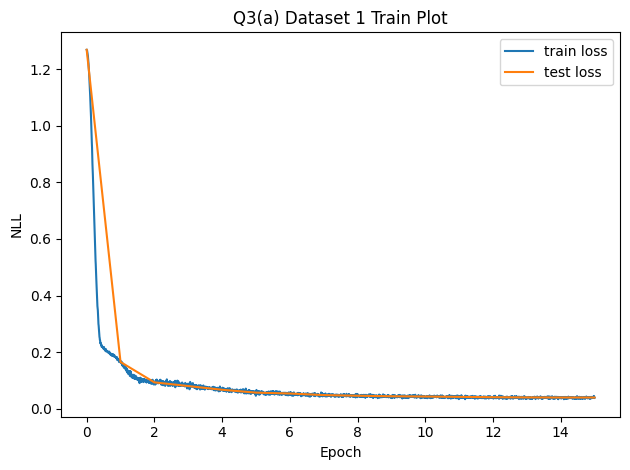

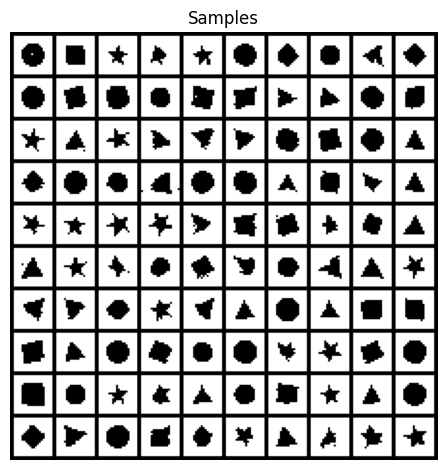

In [23]:
q3ab_save_results(1, 'a', q3_a)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [12:08<00:00, 48.58s/it]


sample_time = 11.105542182922363
Final Test Loss: 0.0803


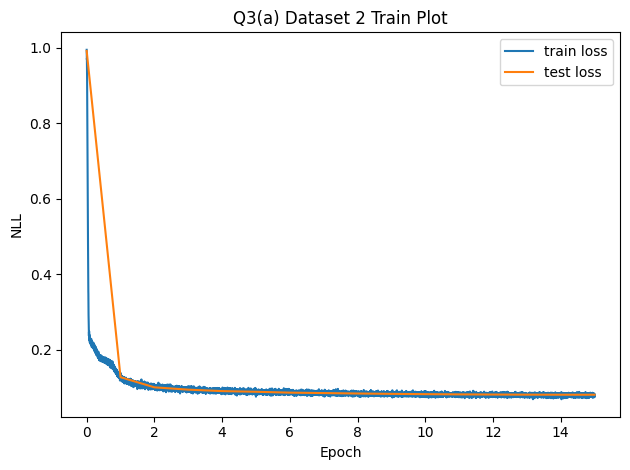

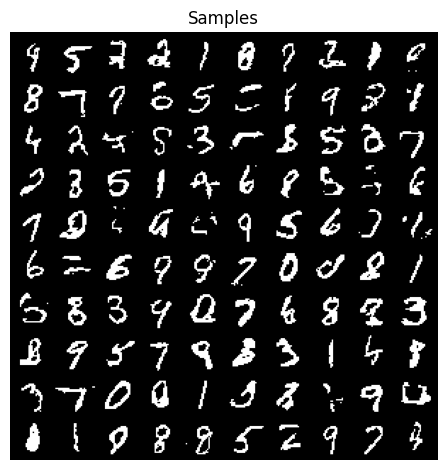

In [24]:
q3ab_save_results(2, 'a', q3_a)

## Part (b) iGPT on Colored Shapes and MNIST

Now, implement an iGPT that models color. In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [4]:
# you might find these helper functions useful
def convert_rgb_to_index(x: np.ndarray):
    """
    Convert RGB image to index image

    :param x: RGB image of shape (B, H, W, 3) with values in [0, 3]
    :return: index image of shape (B, H, W) with values in [0, 63]
    """
    assert x.shape[-1] == 3
    assert np.max(x) <= 3
    assert np.min(x) >= 0
    return np.sum(x * np.array([1, 4, 16]), axis=-1).astype(int) # TODO fill this last line in


def convert_index_to_rgb(x: np.ndarray):
    """
    Convert index image to RGB image

    :param x: index image of shape (B, H, W) with values in [0, 63]
    :return: RGB image of shape (B, H, W, 3) with values in [0, 3]
    """
    assert np.max(x) <= 63
    assert np.min(x) >= 0.0
    assert x.dtype == int
    return np.stack([x % 4, (x % 16) // 4, x // 16, ], axis=-1) # TODO fill this last line in

In [69]:
def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  H, W, C = image_shape
  tf_config = TransformerConfig(
      vocab_size=4**3 + 1,
      block_size=H * W + 1,
      n_embd=256,
      n_head=4,
  )
  sos_token = 4**3
  model = Transformer(tf_config).cuda()

  epochs = 15   
  train_args = dict(epochs=epochs, lr=1e-3, grad_clip=1, use_cos_decay=True, warmup=1000)

  # train_data is of shape (B, Height, Width, Channels), convert to sequence of indices
  B_train = train_data.shape[0]
  B_test = test_data.shape[0]
  train_data = torch.tensor(convert_rgb_to_index(train_data)).long().reshape(B_train, -1)
  test_data = torch.tensor(convert_rgb_to_index(test_data)).long().reshape(B_test, -1)

  # append sos token to the start of each sequence
  train_data = torch.cat([sos_token * torch.ones(train_data.size(0), 1).long(), train_data], dim=1)
  test_data = torch.cat([sos_token * torch.ones(test_data.size(0), 1).long(), test_data], dim=1)

  train_loader = data.DataLoader(train_data, batch_size=32, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=32)

  train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)
    
  # save_trained mode
  save_path = f"model_q3b_{dset_id}.pth"
  torch.save(model.state_dict(), save_path)

  model.eval()
  idx = torch.zeros(100, 1).long().cuda() * sos_token
  generated, _ =  model.generate(idx)
  sequence = generated[:, 1:] # remove sos token

  reshape_samples = sequence.view(-1, H, W).cpu().numpy()
  samples = convert_index_to_rgb(reshape_samples)
  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:02<00:00,  4.19s/it]


Final Test Loss: 0.0523


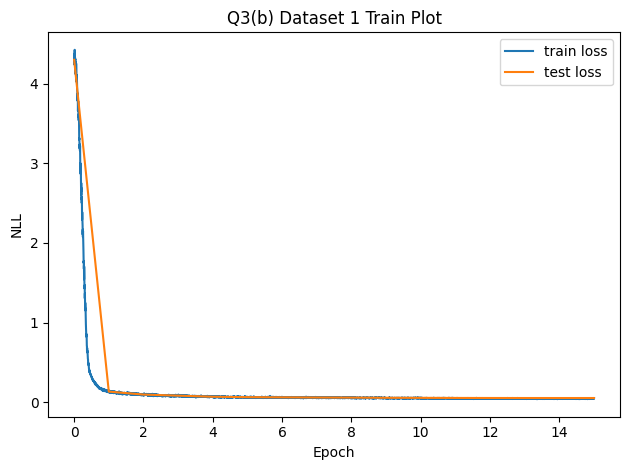

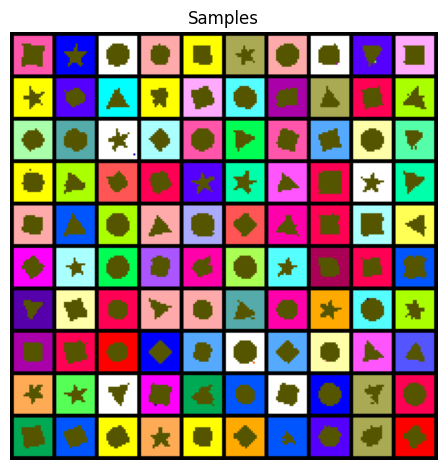

In [70]:
q3ab_save_results(1, 'b', q3_b)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [15:12<00:00, 60.81s/it]


Final Test Loss: 0.0888


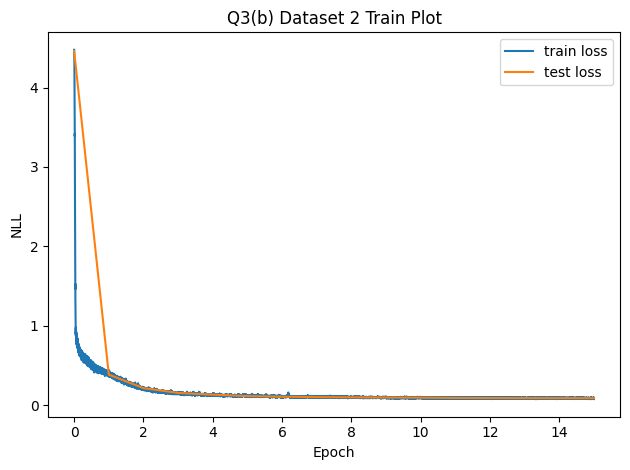

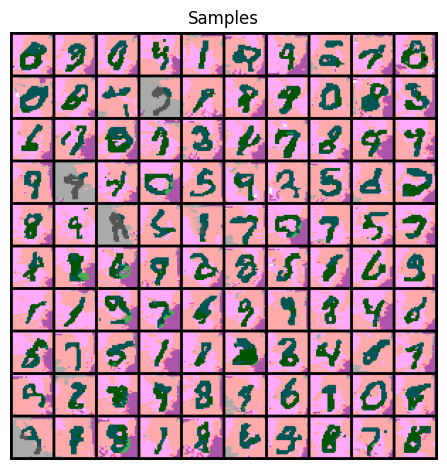

In [71]:
q3ab_save_results(2, 'b', q3_b)

## Part (c) K, V Caching for Improved Inference
You may have noticed that generation from the transformer is quite slow. Part of this is just due to the autoregressive nature. However, another part is due to some computational inefficiency. At each forward pass of the model, we are performing repeat computation of the past sequence. Specifically, we can cache the key and values at the multi attention layer to more quickly predict at each step.

In self-attention, a sequence is processed by generating three vectors for each element in the sequence: a Query (Q), a Key (K), and a Value (V). These vectors are then used to compute attention scores and subsequently the output of the attention layer.
Mathematically, this can be represented as:
 * For each index $i$, compute $Q_i$, $K_i$, $V_i$ for the current element
 * Retrieve $K_{<i}$ and $V_{<i}$ from the cache (where $<i$ denotes all indices before the current one)
 * Compute the attention output using $Q_i$, $[K_{<i}, K_i]$, $[V_{<i}, V_i]$


Next implement caching for your transformer to make inference more efficient by modifying your self attention. Use caching for inference in the future problems for faster generation! (Note caching is only used during inference). You will use the same dataset as in part B, dataset 2 of this question (colored mnist). No training is required in this section, feel free to reuse the model you trained in part B, dataset 2.

**You will provide these deliverables**

1. Over the course of inference, measure the time for the forward pass over the total sequence length with and without caching.
3. 100 samples from the final trained model using the caching inference pipeline.



In [72]:
def load_transformer_model(dset_id, image_shape):
  H, W, C = image_shape
  tf_config = TransformerConfig(
      vocab_size=4**3 + 1,
      block_size=H * W + 1,
      n_embd=256,
      n_head=4,
  )
  
  model = Transformer(tf_config).cuda()
  path = f"model_q3b_{dset_id}.pth"
  model.load_state_dict(torch.load(path))
  return model


In [73]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# sampling steps,) numpy array of time per sampling iteration, without caching
  - a (# sampling steps,) numpy array of time per sampling iteration, with without caching
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated without caching)
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated with caching)
  """
  sos_token = 4**3
  H, W, C = image_shape
  model = load_transformer_model(dset_id, image_shape)
  model.eval()

  # with cache
  idx = torch.zeros(100, 1).long().cuda() * sos_token
  generated, time_list_no_cache =  model.generate(idx)
  sequence = generated[:, 1:] # remove sos token

  reshape_samples = sequence.view(-1, H, W).cpu().numpy()
  samples_no_cache = convert_index_to_rgb(reshape_samples)

  # no with cache
  idx = torch.zeros(100, 1).long().cuda() * sos_token
  generated, time_list_with_cache =  model.generate(idx, cache=True)
  sequence = generated[:, 1:] # remove sos token

  reshape_samples = sequence.view(-1, H, W).cpu().numpy()
  samples_with_cache = convert_index_to_rgb(reshape_samples)
  return time_list_no_cache, time_list_with_cache, samples_no_cache, samples_with_cache

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



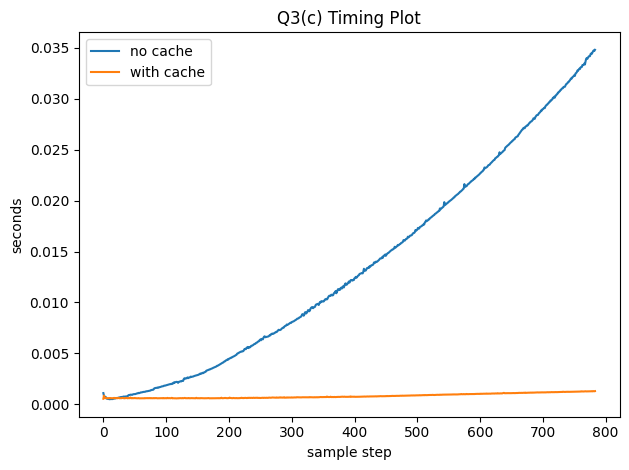

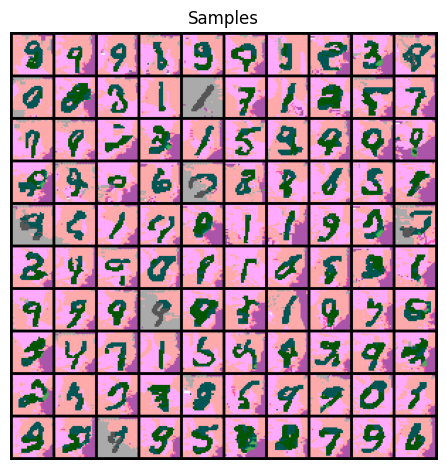

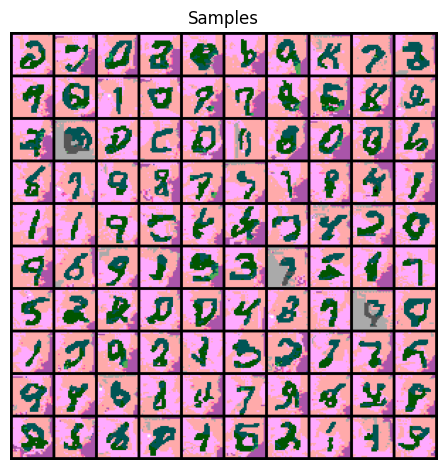

In [74]:
q3c_save_results(2, q3_c)

# Question 4: Causal Transformer: Tokenized Images

## Image Tokenization with Vector Quanization

## Part (a) Image Quantization

Above, we implemented iGPT, which autoregressivly predicts raw pixels. Transformers have quadratic complexity in the sequence length which prevents this naive approach from scaling well to large images.

The space of natural images often contains very correlated information. This suggests we can learn a reduced representation. VQVAE is a method that does just that, learning to map images to a more compact discrete set of tokens. We will cover this method in more detail in future lectures. The only thing you need to know now is that we can learn an encoder (and corresponding decoder), which can extract a discrete representation from an image. 

If you are curious, checkout the VQVAE paper to learn more: https://arxiv.org/abs/1711.00937 (we will cover this in a future lecture though!)

In this part, we provide a pre-trained VQVAE model, which consists of:
 * encoder to tokenize the images
 * the decoder to recover the image
 * a token vocabulary of VQVAE_MODEL.n_embeddings

Below is the code for loading the VQ model. Note that VQVAE encoding process is lossy, so the decoded images will not be the exact same as the input. Some blurriness in the recovered image is to be expected. The docstrings of the relevant methods you will need for the VQVAE_MODEL are provided below for your convenience. 

We will use 2 colored mnist datasets in this part. The first is the same dataset used in previous parts. The second, hads a colored digit on a differently colored background. We will call these datasets Colored MNIST and Colored MNIST v2. Note that the vqvae is trained per dataset.

**You will provide these deliverables**

1. Use the provided encoder model to quantize the images then inspect the recovered images by applying the decoder for each of the two datasets

In [16]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#    
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#    
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
# 

In [87]:
def q4_a(images, vqvae):
  """
  images: (B, H, W, C), the images to pass through the encoder and decoder of the vqvae
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a numpy array of size (2, H, W, C) of the decoded image
  """
  z_index = vqvae.quantize(images)
  assert z_index.shape[-1] == z_index.shape[-2]
  assert len(z_index.shape) == 3
  autoencoded_images = vqvae.decode(z_index)
  return autoencoded_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(11)
tensor(1020)
-0.18384123
3.3049955


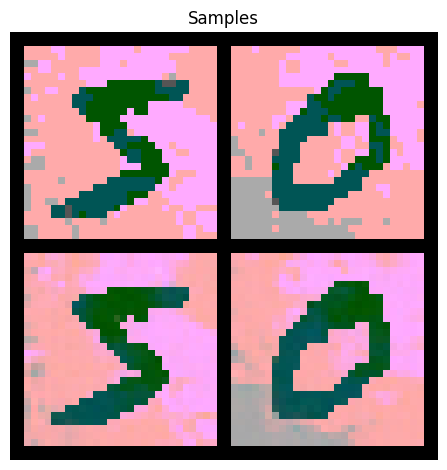

In [49]:
q4a_save_results(1, q4_a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


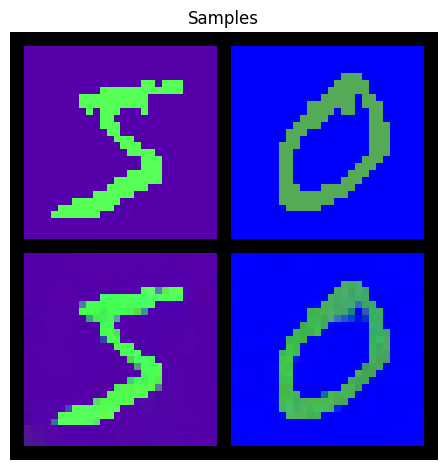

In [19]:
q4a_save_results(2, q4_a)

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

In [12]:
# you might find these helper functions useful
def convert_rgb_to_tokens(x: np.ndarray, vqvae):
    """
    Convert RGB image to index image

    :param x: RGB image of shape (B, H, W, 3) with values in [0, 3]
    :return: index image of shape (B, H, W) with values in [0, 63]
    """
    assert x.shape[-1] == 3
    assert np.max(x) <= 3
    assert np.min(x) >= 0
    return vqvae.quantize(x)


def convert_tokens_to_rgb(x: np.ndarray, vqvae):
    """
    Convert index image to RGB image

    :param x: index image of shape (B, H, W) with values in [0, 63]
    :return: RGB image of shape (B, H, W, 3) with values in [0, 3]
    """
    assert np.max(x) <= vqvae.n_embeddings
    assert np.min(x) >= 0.0
    assert x.dtype == int
    x = vqvae.decode(x)
    return np.clip(np.round(x), 0, 3)

In [101]:
def q4_b(train_data, test_data, image_shape, dset_id, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets
  vqvae: a vqvae model, trained on dataset dset_id

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
  """
  VQ_S = 7
  tf_config = TransformerConfig(
      vocab_size=vqvae.n_embeddings + 1,
      block_size=VQ_S**2 + 1,
      n_layer=4,
      n_embd=256,
      n_head=4,
  )
  sos_token = vqvae.n_embeddings
  model = Transformer(tf_config).cuda()
  epochs = 30
  train_args = dict(epochs=epochs, lr=1e-3, grad_clip=1, use_cos_decay=True, warmup=1000)

  # train_data is of shape (B, Height, Width, Channels), convert to sequence of indices
  B_train = train_data.shape[0]
  B_test = test_data.shape[0]
    
  train_data = torch.tensor(convert_rgb_to_tokens(train_data, vqvae)).long().reshape(B_train, -1)
  test_data = torch.tensor(convert_rgb_to_tokens(test_data, vqvae)).long().reshape(B_test, -1)

  # append sos token to the start of each sequence
  train_data = torch.cat([sos_token * torch.ones(train_data.size(0), 1).long(), train_data], dim=1)
  test_data = torch.cat([sos_token * torch.ones(test_data.size(0), 1).long(), test_data], dim=1)
    
  train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=64)

  train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)

  model.eval()
  idx = torch.zeros(100, 1).long().cuda() * sos_token
  generated, _ =  model.generate(idx)
  sequence = generated[:, 1:]
  reshape_samples = sequence.view(-1, VQ_S, VQ_S).cpu().numpy()

  samples = convert_tokens_to_rgb(reshape_samples, vqvae)
  
  return train_losses, test_losses, samples

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



/tmp/ipykernel_698683/2864561086.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(convert_rgb_to_tokens(train_data, vqvae)).long().reshape(B_train, -1)
/tmp/ipykernel_698683/2864561086.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(convert_rgb_to_tokens(test_data, vqvae)).long().reshape(B_test, -1)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:13<00:00,  4.44s/it]


-10.265171 4.9028735
Final Test Loss: 3.7385


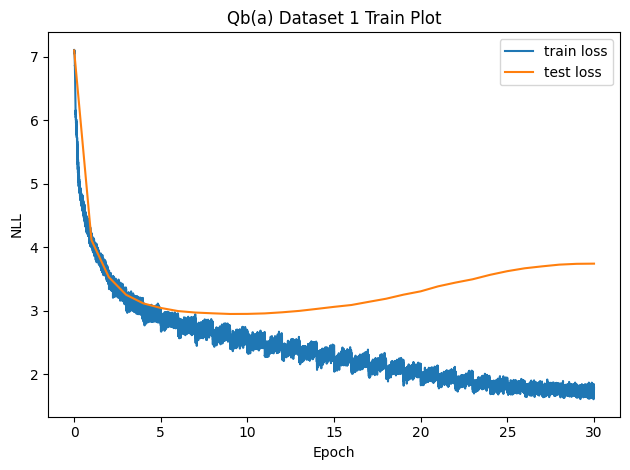

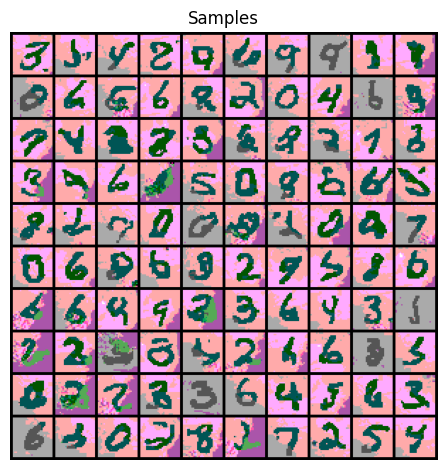

In [102]:
q4b_save_results(1, q4_b)

/tmp/ipykernel_698683/2864561086.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(convert_rgb_to_tokens(train_data, vqvae)).long().reshape(B_train, -1)
/tmp/ipykernel_698683/2864561086.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(convert_rgb_to_tokens(test_data, vqvae)).long().reshape(B_test, -1)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:19<00:00,  4.65s/it]


-1.1063809 4.832313
Final Test Loss: 3.7678


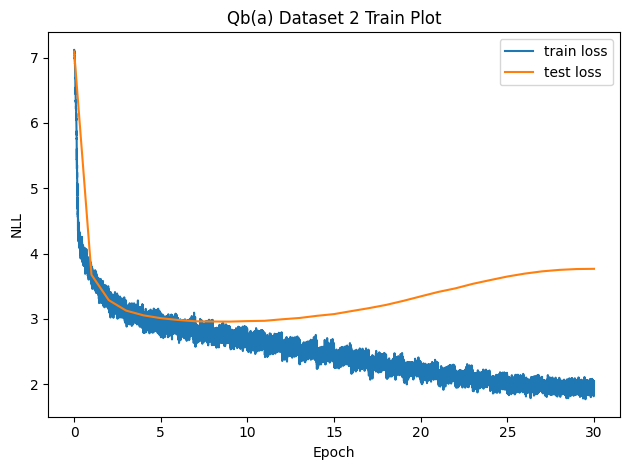

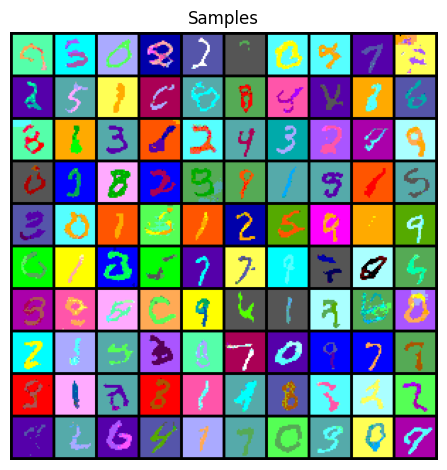

In [103]:
q4b_save_results(2, q4_b)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [24]:
data = visualize_q5_data()

Sample 1
[i carry your heart with me(i carry it in] Copyright 1952,  1980, 1991 by the Trustees for the E. E. Cummings Trust, from Complete Poems: 1904-1962 by E. E. Cummings, edited by George J. Firmage. Used by permission of Liveright Publishing Corporation.
--------------------------------------------------------------------------------

Sample 2
Take all my loves, my love, yea, take them all:
What hast thou then more than thou hadst before?
No love, my love, that thou mayst true love call
All mine was thine before thou hadst this more.
Then if for my love thou my love receivest,
I cannot blame thee for my love thou usest;
But yet be blamed if thou this self deceivest
By wilful taste of what thyself refusest.
I do forgive thy robbry, gentle thief,
Although thou steal thee all my poverty;
And yet love knows it is a greater grief
To bear loves wrong than hates known injury.
    Lascivious grace, in whom all ill well shows,
    Kill me with spites, yet we must not be foes.
------------

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [33]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, chunk_size):
        """
        Initialize the dataset with a list of texts, a tokenizer, and a specified chunk size.
        """
        self.tokenizer = tokenizer
        self.chunk_size = chunk_size
        self.data = []

        # Process each text
        for text in texts:
            # Convert text to token IDs with BOS and EOS tokens
            tokenized_text = [tokenizer.token2idx['<bos>']] + tokenizer.convert_tokens_to_ids(text) + [tokenizer.token2idx['<eos>']]
            
            # Split into overlapping chunks  
            for i in range(0, len(tokenized_text) - chunk_size):
                self.data.append(tokenized_text[i:i + chunk_size])

    def __len__(self):
        """
        Return the number of chunks in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Return the tokenized text chunk (as tensor) at the given index.
        """
        tokenized_chunk = self.data[idx]
        # Pad chunk if it's shorter than chunk_size
        padded_chunk = tokenized_chunk + [0] * (self.chunk_size - len(tokenized_chunk))
        return torch.tensor(padded_chunk, dtype=torch.long)

class SimpleTokenizer:
    def __init__(self):
        # Dictionary for token-to-index mapping
        self.token2idx = {}
        self.idx2token = {}

    def convert_tokens_to_ids(self, text):
        """
        Convert a string of text into a list of corresponding indices.
        """
        return [self.token2idx[char] for char in text]

    def convert_ids_to_tokens(self, ids):
        """
        Convert a list of indices back into a string.
        """
        return ''.join(self.idx2token[idx] for idx in ids)

    def build_vocab(self, texts):
        """
        Builds the vocabulary from a list of texts.
        """
        unique_chars = set(char for text in texts for char in text)
        for idx, char in enumerate(unique_chars):
            self.token2idx[char] = idx
            self.idx2token[idx] = char


tokenizer = SimpleTokenizer()
sample_texts = ["I love deepUL!", "Hello, world"]
tokenizer.build_vocab(sample_texts)
tokenizer.token2idx['<bos>'] = len(tokenizer.token2idx)
tokenizer.token2idx['<eos>'] = len(tokenizer.token2idx)
tokenizer.idx2token[len(tokenizer.idx2token)] = '<bos>'
tokenizer.idx2token[len(tokenizer.idx2token)] = '<eos>'

# Creating the dataset with a specified chunk size
chunk_size = 10
text_dataset = TextDataset(sample_texts, tokenizer, chunk_size)

# Example: Accessing items in the dataset
for i in range(len(text_dataset)):
    print(f"Chunk {i}: Token IDs:", text_dataset[i].tolist())
    print(f"Chunk {i}: Text:", tokenizer.convert_ids_to_tokens(text_dataset[i].tolist()))

Chunk 0: Token IDs: [15, 11, 9, 10, 6, 3, 13, 9, 1, 13]
Chunk 0: Text: <bos>I love de
Chunk 1: Token IDs: [11, 9, 10, 6, 3, 13, 9, 1, 13, 13]
Chunk 1: Text: I love dee
Chunk 2: Token IDs: [9, 10, 6, 3, 13, 9, 1, 13, 13, 8]
Chunk 2: Text:  love deep
Chunk 3: Token IDs: [10, 6, 3, 13, 9, 1, 13, 13, 8, 4]
Chunk 3: Text: love deepU
Chunk 4: Token IDs: [6, 3, 13, 9, 1, 13, 13, 8, 4, 14]
Chunk 4: Text: ove deepUL
Chunk 5: Token IDs: [3, 13, 9, 1, 13, 13, 8, 4, 14, 5]
Chunk 5: Text: ve deepUL!
Chunk 6: Token IDs: [15, 7, 13, 10, 10, 6, 12, 9, 0, 6]
Chunk 6: Text: <bos>Hello, wo
Chunk 7: Token IDs: [7, 13, 10, 10, 6, 12, 9, 0, 6, 2]
Chunk 7: Text: Hello, wor
Chunk 8: Token IDs: [13, 10, 10, 6, 12, 9, 0, 6, 2, 10]
Chunk 8: Text: ello, worl
Chunk 9: Token IDs: [10, 10, 6, 12, 9, 0, 6, 2, 10, 1]
Chunk 9: Text: llo, world


In [34]:
import torch.utils.data as data
def q5_a(train_text, test_text):
  """
  train_text: list[str] Train text sequences.
  test_text: list[str] Test text sequences.

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 5 (str), 5 generated samples from the model.
  """
  epochs = 5

  print(len(train_text))
  print(len(test_text))
  tokenizer = SimpleTokenizer()
  tokenizer.build_vocab(train_text)
  tokenizer.token2idx['<eos>'] = len(tokenizer.token2idx)
  tokenizer.token2idx['<bos>'] = len(tokenizer.token2idx)
  tokenizer.idx2token[len(tokenizer.idx2token)] = '<eos>'
  tokenizer.idx2token[len(tokenizer.idx2token)] = '<bos>'
  assert len(tokenizer.idx2token) == len(tokenizer.token2idx)

  # Creating the dataset with a specified chunk size
  chunk_size = 128
  train_sequences = TextDataset(train_text, tokenizer, chunk_size)
  test_sequences = TextDataset(test_text, tokenizer, chunk_size)

  print(len(train_sequences))
  print(len(test_sequences))
    
  train_loader = data.DataLoader(train_sequences, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_sequences, batch_size=128)
    
  tf_config = TransformerConfig(
      vocab_size=len(tokenizer.token2idx),
      block_size=chunk_size,
      n_layer=2,
      n_head=4,
  )
  model = Transformer(tf_config).cuda()
  train_args = dict(
      epochs=epochs,
      lr=1e-3,
      grad_clip=1,
      use_cos_decay=True,
      warmup=1000
  )
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)  
  import time
  model.eval()
  time_s = time.time()
  idx = torch.ones(5, 1).long().cuda() * tokenizer.token2idx['<bos>']
  generated, _ =  model.generate(
   idx,
   chunk_size,
   temperature=1,
  )
  sequence = generated.detach().cpu().numpy() # generated is of shape (b, t+1) so exclude leading token
  print(f"sample_time = {time.time()-time_s}")
  text_samples = []
  for seq in sequence:
    txt = tokenizer.convert_ids_to_tokens(seq)
    text_samples.append(txt)

  return train_losses, test_losses, text_samples

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



563
10
487403
8877


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:48<00:00, 21.60s/it]


sample_time = 0.12740826606750488
Final Test Loss: 2.1299


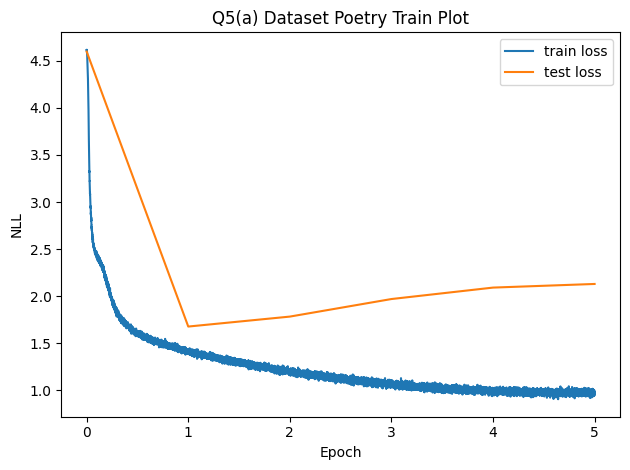

Sample 1
<bos>Flake then in life well even in blossoming green,
With that thou thy life, and a hony-chosether.

I muse lovers go to purn,


Sample 2
<bos>II have defer'd thee:
What I all the wind by the peer spent?
O mare above the gray was,) to lull, as thou this?
I am faire fu

Sample 3
<bos>That is light doth, and no man will be thy love.

Time doth to an hollow great,
Racker to whose and due the end,
Their loddu

Sample 4
<bos>kis is not breakin',
Though some fear'd with brok's blue sackness of middle Spadnights,
Your face, as well o'er to the ever ow

Sample 5
<bos>"DI Phyman Love, Macos Heaven buyrself, honoured peers;
For like the divine in thyself to was and fro.

A holdeth with goes, 



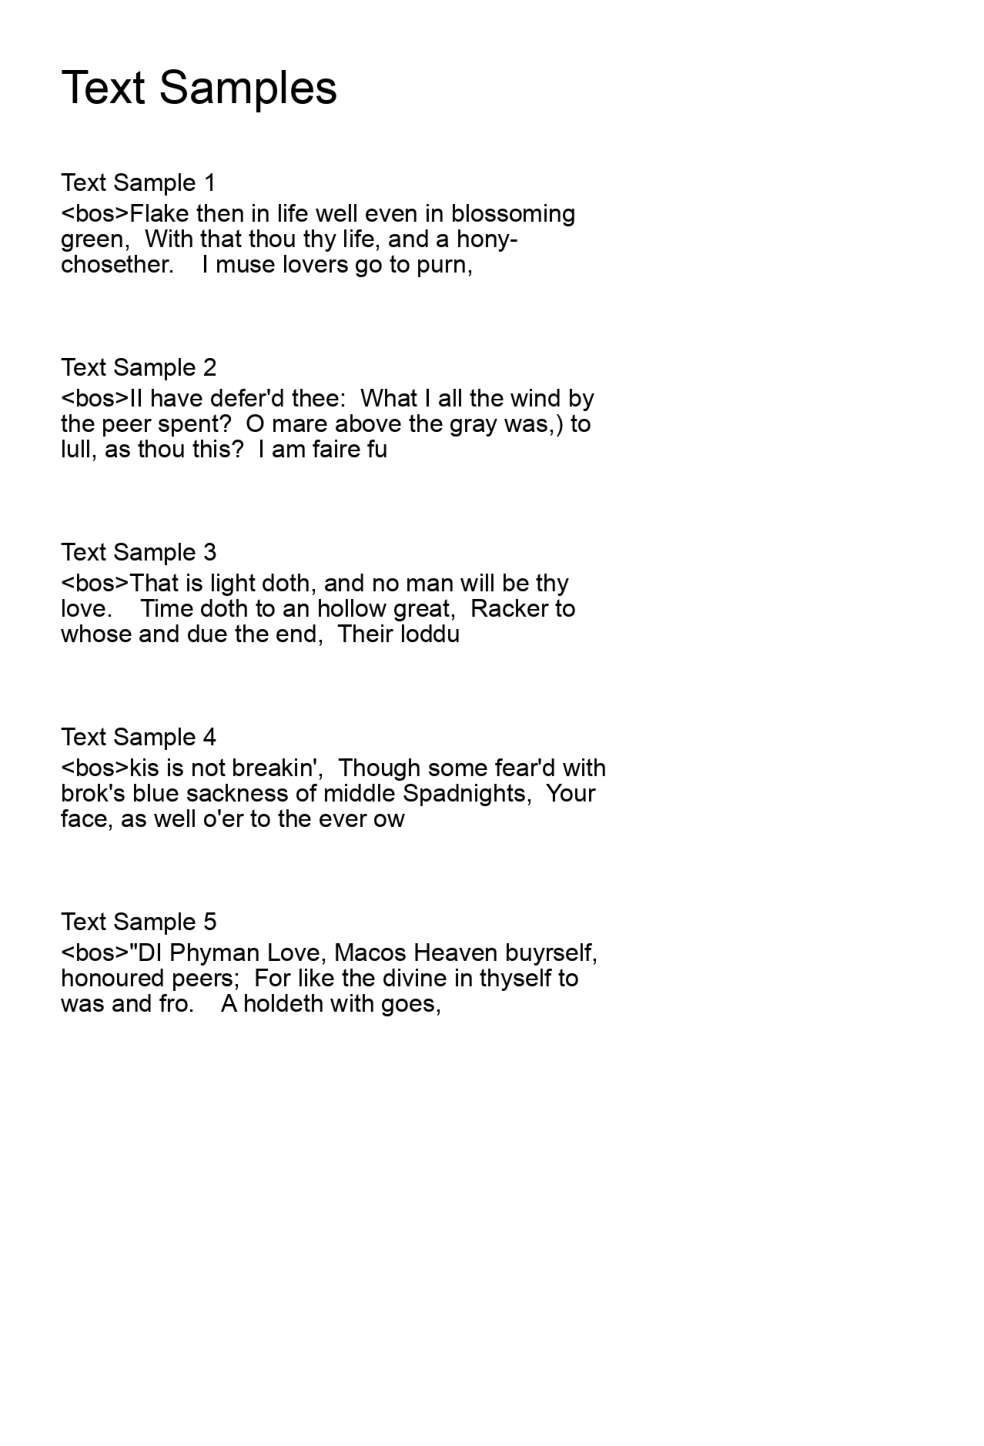

In [27]:
q5a_save_results(q5_a)

# Question 6: Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

We will use the text labeled colored MNIST dataset, which has a text description of the MNIST image. Run the cell below to visualize the data along with the text annotation. This is the Colored MNIST v2 dataset, which also comes with these text labels.

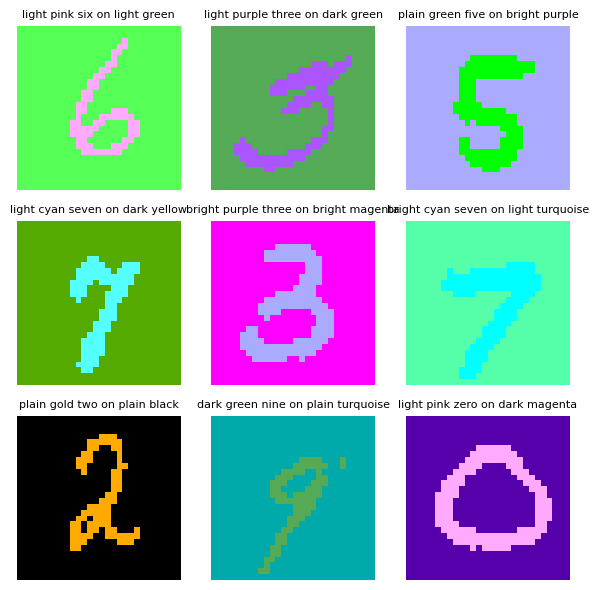

In [28]:
visualize_q6_data()

## Part (a) Multimodal Text and Image Generation
Implement and train an autoregressive (AR) model capable of handling both text and image data. The model should be designed to process sequences composed of concatenated text and image tokens in both orders (text followed by images and images followed by text). Additionally, the model should be capable of generating unconditional text and image samples.

Data Preprocessing:
* Text Tokens: Map each unique word in the text data to a unique token. (Note that all text descriptions contain the exact same amount of words. This simplifies text processing, as you won't have to deal with sequences of different lengths as in Question 5)
* Image Tokens: Quantize the image data into tokens using the VQVAE tokenizer from Problem 4.
* In this problem, we have 2 modalities. Introduce an **\<end of text\>** token and an **\<end of image\>** token. After seeing such a token, the model should switch to sampling the next modality.
* Formulate batches as sequences of concat([**\<end of image\>**, text_tokens, **\<end of text\>**, image_tokens]) and concat([**\<end of text\>**, image_tokens, **\<end of image\>**, text_tokens]). With a 50/50 split between each ordering.

Inference:
* During inference, we cannot mix modality tokens. During sampling we can restrict the logits to only be within the relevant modality.
* After **\<end of image\>**, only allow the model to sample text tokens (including **\<end of text\>**)
* After **\<end of text\>**, only allow the model to sample image tokens (including **\<end of image\>**)
* At the very start (conditioned on the **\<bos\>** token, only allow the model to sample one of (**\<end of image\>** or **\<end of text\>**))
* As the model may not always correctly sample the **\<end of image\>** token before the image ends, you may add a rule to force the model to always sample the correct number of image tokens (49 tokens).

You can use the same hyperparameters as in 4(b) (but of course, feel free to tune your model to achieve better performance)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 9 conditional samples based on provided text.
4. 9 conditional samples based on provided images.
5. 9 unconditional samples showcasing the model's capability in generating standalone text and images.

In [5]:
import numpy as np

class TextWordTokenizer:
    def __init__(self):
        self.word_to_token = {}
        self.token_to_word = {}

    def fit(self, text_data):
        """Create a vocabulary of unique words and map them to unique tokens."""
        vocabulary = set(word for sentence in text_data for word in sentence.split())
        self.word_to_token = {word: i for i, word in enumerate(vocabulary)}
        self.token_to_word = {i: word for word, i in self.word_to_token.items()}

    def tokenize(self, text_data):
        """Convert a list of text data to a list of tokenized data."""
        return [[self.word_to_token[word] for word in sentence.split()] for sentence in text_data]

    def detokenize(self, tokenized_data):
        """Convert a list of tokenized data back to text data."""
        return [" ".join(self.token_to_word.get(token, '') for token in sentence) for sentence in tokenized_data]

train_text = [
    "bright yellow five on bright magenta",
    "light pink five on bright magenta",
]

# Tokenize the training set
tokenizer = TextWordTokenizer()
tokenizer.fit(train_text)

train_text_tokens = tokenizer.tokenize(train_text)
de_text = tokenizer.detokenize(train_text_tokens)
print("Train text original:", train_text)
print("Train text tokens  :", train_text_tokens)
print("Train text decoded :", de_text)

Train text original: ['bright yellow five on bright magenta', 'light pink five on bright magenta']
Train text tokens  : [[1, 3, 5, 0, 1, 4], [2, 6, 5, 0, 1, 4]]
Train text decoded : ['bright yellow five on bright magenta', 'light pink five on bright magenta']


In [6]:
class DataConverter:
    def __init__(self, text_tokenizer, vqvae):
        """
        Initializes the DataConverter with a given text tokenizer.

        :param text_tokenizer: An instance of TextWordTokenizer for handling text tokenization.
        """
        self.vqvae = vqvae
        self.text_tokenizer = text_tokenizer
        self.max_text_token = max(text_tokenizer.word_to_token.values())
        self.end_of_text_token = self.max_text_token + 1
        self.end_of_image_token = self.max_text_token + vqvae.n_embeddings + 1
        self.bos_token = self.end_of_image_token + 1
        self.size = self.bos_token + 1

        self.end_of_text_token_t = torch.tensor([self.end_of_text_token])
        self.end_of_image_token_t = torch.tensor([self.end_of_image_token])
        self.bos_token_t = torch.tensor([self.bos_token])

    def convert_to_tokens(self, image_data, text_data):
        """
        Converts image and text data to a unified tokenized format.

        :param image_data: Image data to be tokenized.
        :param text_data: Text data to be tokenized.
        :return: A list of tokenized sequences combining image and text tokens.
        """
        # Offset for image tokens to ensure uniqueness
        image_tokens = self.convert_image_to_tokens(image_data)

        # Tokenize text data
        text_tokens = self.convert_text_to_tokens(text_data)

        # Create concatenated sequences
        image_text_sequences = [
            torch.cat(
                [self.bos_token_t, self.end_of_text_token_t , img_tok, self.end_of_image_token_t, torch.tensor(txt_tok, dtype=torch.long)]
            ) for img_tok, txt_tok in zip(image_tokens, text_tokens)]
        
        text_image_sequences = [
            torch.cat(
                [self.bos_token_t, self.end_of_image_token_t, torch.tensor(txt_tok, dtype=torch.long), self.end_of_text_token_t, img_tok]
            ) for img_tok, txt_tok in zip(image_tokens, text_tokens)
        ]

        # Combine and shuffle sequences
        sequences = image_text_sequences + text_image_sequences
        np.random.shuffle(sequences)
        return sequences

    def convert_image_to_tokens(self, image_data):
        # Offset for image tokens to ensure uniqueness
        image_token_offset = self.end_of_text_token + 1
        B = image_data.shape[0]
        image_tokens = torch.tensor(convert_rgb_to_tokens(image_data, self.vqvae)).long().reshape(B, -1)
        image_tokens += image_token_offset
        image_tokens = image_tokens.reshape(len(image_data), -1)
        return image_tokens
        
    def convert_text_to_tokens(self, text_data):
        text_tokens = self.text_tokenizer.tokenize(text_data)
        return text_tokens

    def convert_to_image(self, image_tokens):
        """
        Converts image tokens back to image data.

        :param image_tokens: Tokenized image data.
        :return: Original image data.
        """
        # Adjust the tokens back to original values
        image_token_offset = self.max_text_token + 2
        adjusted_tokens = image_tokens - image_token_offset

        B, L = adjusted_tokens.shape
        assert np.sqrt(L) == int(np.sqrt(L))
        adjusted_tokens = adjusted_tokens.reshape(B, int(np.sqrt(L)), int(np.sqrt(L)))
        return convert_tokens_to_rgb(adjusted_tokens, self.vqvae)

    def convert_to_text(self, text_tokens):
        """
        Converts text tokens back to text data.

        :param text_tokens: Tokenized text data.
        :return: Original text data.
        """
        return self.text_tokenizer.detokenize(text_tokens)

    def convert_sequence_to_text_and_images(self, sequence):
        """
        Converts a sequence of tokens back into its respective image and text formats.

        :param sequence: A sequence of tokens combining image and text tokens.
        :return: A tuple of (image, text) or (text, image), depending on the sequence format.
        """
        separator_index = (sequence == self.separator_token).nonzero(as_tuple=True)[0].item()

        if separator_index > len(sequence) // 2:  # Indicates image-text format
            image_tokens = sequence[:separator_index]
            text_tokens = sequence[separator_index + 1:]
            return (self.convert_to_image(image_tokens), self.convert_to_text(text_tokens))
        else:  # Indicates text-image format
            text_tokens = sequence[:separator_index]
            image_tokens = sequence[separator_index + 1:]
            return (self.convert_to_text(text_tokens), self.convert_to_image(image_tokens))

    def text_logit_mask(self) -> torch.Tensor:
        """has 1 where the text tokens are, 0 elsewhere"""
        mask = torch.zeros(self.size)
        mask[:self.end_of_text_token] = 1
        return mask

    def image_logit_mask(self) -> torch.Tensor:
        """has 1 where the image tokens are, 0 elsewhere"""
        mask = torch.zeros(self.size)
        mask[self.end_of_text_token + 1 : self.end_of_image_token] = 1
        return mask
        
    def end_of_mask(self) -> torch.Tensor:
        mask = torch.zeros(self.size)
        mask[self.end_of_image_token] = 1
        mask[self.end_of_text_token] = 1
        return mask

In [10]:
def q6_a(train_data, test_data, image_shape, train_text, test_text, image_test_prompt, text_test_prompt, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: tuple (H, W, C) The shape of the images in the dataset, indicating height, width, and number of color channels.
  train_text: list[str] Text data associated with each training image.
  test_text: list[str] Text data associated with each test image.
  image_test_prompt: (9, H, W, C) Image data used for generating conditional text samples during testing.
  text_test_prompt: list of 9 strings Text prompts used for generating conditional image samples during testing.
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 9 (image, text), corresponding to the image conditioned samples
  - a list of 9 (image, text), corresponding to the text conditions samples
  - a list of 9 (image, text), corresponding to unconditional samples
  """
  epochs = 30
  train_args = dict(
      epochs=epochs,
      lr=1e-4,
      grad_clip=1,
      use_cos_decay=True,
      warmup=1000
  )

  # # train_data is of shape (B, Height, Width, Channels), convert to sequence of indices
  tokenizer = TextWordTokenizer()
  tokenizer.fit(train_text)

  converter = DataConverter(tokenizer, vqvae)
  train_sequences = converter.convert_to_tokens(train_data, train_text)
  test_sequences = converter.convert_to_tokens(test_data, test_text)
  sequence_lengths = len(train_sequences[0])
    
  train_loader = data.DataLoader(train_sequences, batch_size=64, shuffle=True)
  test_loader = data.DataLoader(test_sequences, batch_size=64)

  tf_config = TransformerConfig(
      vocab_size=converter.size,
      block_size=sequence_lengths,
      n_layer=6,
      n_head=4,
      n_embd=128,
  )
  model = Transformer(tf_config).cuda()
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)

  # sample images conditional
  prompt_tokens = converter.convert_image_to_tokens(image_test_prompt)

  B, _ = prompt_tokens.shape
  prompt = torch.cat([
      torch.ones(B, 1).long() * converter.bos_token,
      torch.ones(B, 1).long() * converter.end_of_text_token,
      torch.tensor(prompt_tokens),
      torch.ones(B, 1).long() * converter.end_of_image_token,
  ], dim=1)
  logit_mask = converter.text_logit_mask()
  generated, _ =  model.generate(
   prompt.cuda(), 6, logit_mask=logit_mask
  )
  generated_text_tokens = generated[:, -6:]
  generated_text = converter.convert_to_text(generated_text_tokens.cpu().numpy())
  samples_image_conditioned = list(zip(image_test_prompt, generated_text))

  # sample text conditional
  prompt_tokens = torch.tensor(converter.convert_text_to_tokens(text_test_prompt))
  prompt = torch.cat([
      torch.ones(B, 1).long() * converter.bos_token,
      torch.ones(B, 1).long() * converter.end_of_image_token,
      prompt_tokens,
      torch.ones(B, 1).long() * converter.end_of_text_token,
  ], dim=1)
  logit_mask = converter.image_logit_mask()
  generated, _ =  model.generate(
   prompt.cuda(), 49, logit_mask=logit_mask
  )
  generated_image_tokens = generated[:, -49:]
  generated_images = converter.convert_to_image(generated_image_tokens.cpu().numpy())
  samples_text_conditioned = list(zip(generated_images, text_test_prompt))

  samples_unconditioned = []
  for i in range(9):
      prompt = torch.ones(1, 1).long() * converter.bos_token
      end_mask = converter.end_of_mask()
      sample, _ = model.generate(prompt.cuda(), 1, logit_mask=end_mask)
      if sample[0, -1] == converter.end_of_text_token:
          logit_mask = converter.image_logit_mask()
          sample, _ = model.generate(sample.cuda(), 49, logit_mask=logit_mask)
          image_sample = converter.convert_to_image(sample[:, -49:].cpu().numpy())
          sample = torch.cat([sample, torch.ones(1, 1).cuda().long() * converter.end_of_image_token ], dim=1)
          sample,_ = model.generate(sample.cuda(), 6, logit_mask=converter.text_logit_mask())
          text_sample = converter.convert_to_text(sample[:, -6:].cpu().numpy())
          samples_unconditioned.append((image_sample[0], text_sample[0]))
      else:
          logit_mask = converter.text_logit_mask()
          sample, _ = model.generate(sample.cuda(), 6, logit_mask=logit_mask)
          text_sample = converter.convert_to_text(sample[:, -6:].cpu().numpy())
          sample = torch.cat([sample, torch.ones(1, 1).cuda().long() * converter.end_of_text_token ], dim=1)
          sample,_ = model.generate(sample.cuda(), 49, logit_mask=converter.image_logit_mask())
          image_sample = converter.convert_to_image(sample[:, -49:].cpu().numpy())
          samples_unconditioned.append((image_sample[0], text_sample[0]))

  return train_losses, test_losses, samples_image_conditioned, samples_text_conditioned, samples_unconditioned

### Results

Once you've implemented `q6_a`, execute the cells below to visualize and save your results



/tmp/ipykernel_712420/2658644514.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tokens = torch.tensor(convert_rgb_to_tokens(image_data, self.vqvae)).long().reshape(B, -1)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:56<00:00,  7.90s/it]
/tmp/ipykernel_712420/1200831501.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(prompt_tokens),


Final Test Loss: 2.6196


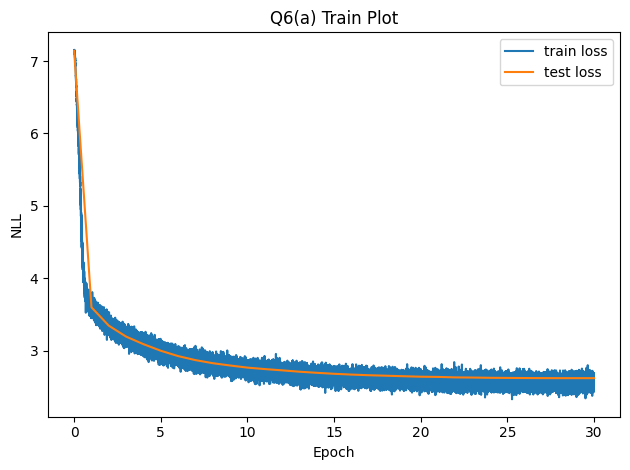

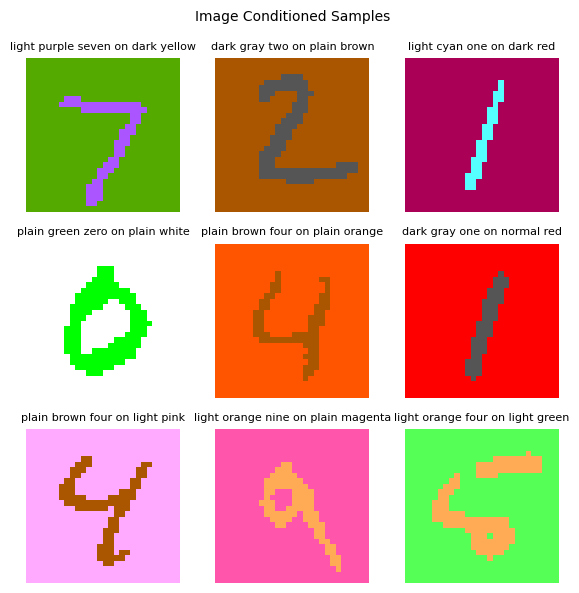

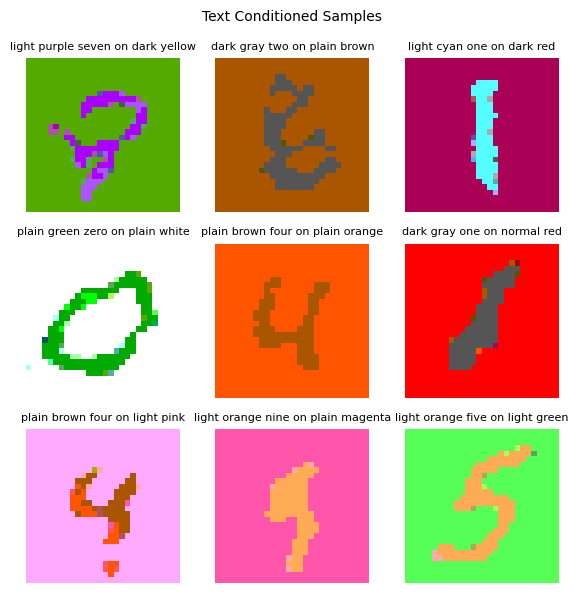

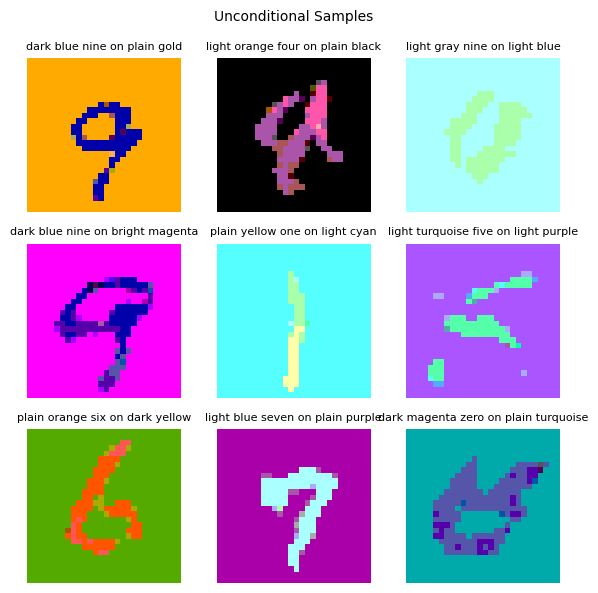

In [13]:
q6a_save_results(q6_a)